The first step to dealing with data is taking care of bookkeeping.  This includes changing the time to be more represantive (more on the later) and  removing outliers. This is not specifically flux outliers, because those can be hard to identify without a model for the data. We'll assume in this tutorial that you do not have such a model. If you develop one later, you can always go back and redo this analysis. 

The first step is to load all the necessary modules. Keep in mind you are always allowed to write your own, but there are some available. These routines have not been rigorously tested, and therefore come with no guarantees. However, they will provide at least a reasonable starting point. We will start by loading the necessary outside packages.

In [22]:
import numpy as np 
import scipy.interpolate as scInterp
import matplotlib.pyplot as plt
import statsmodels.api as sm
#enable inline plots
%matplotlib inline

And now we will load the BRITE DC routines we will need for this tutorial.

In [23]:

from BRITE_decor.inout import load_alt as load
from BRITE_decor.analysis import extra as be
import BRITE_decor.timing.hjdcorrection as hjdcorrectionBRITE
import BRITE_decor.timing.orbit as orbitBRITE

import BRITE_decor.clipping.medianclipping as medianclipBRITE
import BRITE_decor.clipping.percentageclipping as percentageclipBRITE

BRITE data has become quite uniform, but the first couple observations
had some different issues. Specifically, at times stacking was applied Since the timing applied is always the START time of observation, it can be off slightly as stacked observations have time between each exposure which are not accounted for. A simple function to take your setup file and convert to the correct median observation time is given below.

In [24]:
def adjust_timing(HJD, JD, exposureTIME, numberSTACKS, **kwargs):
    """
    A simple routine to convert the HJD to the proper mid-exposure HJDs.
    
    @kwargs: STACKtime: time it takes to stack two observations - Default is 14 [s] (appropriate for almost all observations).
    """
    stackTIME = kwargs.get('STACKtime', 14.0) #[s] 
    
    # Step 1: Get a representation for the current heliocentric correction.
    heliocentricCORRECTION = (HJD - JD) * 24. * 3600. #s      
    tckHELLCORR = hjdcorrectionBRITE.determineHELLCORR(JD, heliocentricCORRECTION)
    
    # Step 2: Determine the mid-observation JD times.
    JD__midOBSERVATION = hjdcorrectionBRITE.determineMIDobsTIME(JD, exposureTIME, stackTIME, np.unique(numberSTACKS))
    
    # Step 3: Determine the heliocentric correction for the corrected JD times.
    heliocentricCORRECTION__midOBSERVATION = scInterp.splev(JD__midOBSERVATION, tckHELLCORR)
    
    # Step 4: Apply the heliocentric correction to the corrected JD times.
    HJD__midOBSERVATION = JD__midOBSERVATION + heliocentricCORRECTION__midOBSERVATION/(3600.*24.)
    
    return HJD__midOBSERVATION


Now we have to load our data file. Since BRITE data files have a very specific formate for how the filename is written. We can load a file without knowing it's name. We just have to define a few specific quantities. We will also use these to save the file later. Of course you can just apply the filename also if you would like.

In [25]:
targ = 'HD37043' # has to be HD number
tel = 'UBr' #telescope abbreviation
obnum = 1 #observation number
obsid = 'OrionI-2013' #observation field and year
setup = 7
release = 2
typ = 'stare' #options are stare and chop

Now you get to load the file. You can do this on your own, but there are convenience functions which are always useful. Brite_Decor has it's own way of doing it, but since I have my own particular style I use a slightly different one. This function loads, the data as a 2D array and two dictionaries. The first dictionary, "columns",  gives you the name of each data column and it's location in the array (i.e. since 'HJD' is the first column, which is 0 in python columns['HJD'] = 0). The second dictionary is "params" which loads all the keywords in the header and their values. We will also use params to save important information from our reduction process.

First define the path to your data. In this example we have put all the data in example_data. If your code is in the same directory as the data set pathIN to None.

In [17]:
pathIN = 'example_data/'

Now we can just give the filename, but if we want to be a little fancy (in this example it has no real purpose but if you are doing this analysis with several files it can add some convenience) we can create the file name from the parameters we have defined above.

In [18]:
filename = load.create_filename(targ, tel, obnum, obsid, setup, release, typ=typ)

data,  columns, params = load.load_dataset(filename, pathIN = pathIN)

Now that we have data it's important to make sure it all fits together nicely. Sometimes data is stacked (multiple exposures in one downloaded image) in one setup and not in another, or in one satellite and not in another. To make things consistent we will transform all the times so that they display observation midpoint as opposed to the observation start time.

In [19]:
HJD = data[:,columns['HJD']]
JD = data[:,columns['JD']]
exptime =  data[:,columns['exptime']]
stack = data[:,columns['stack']]

HJDcorrected = adjust_timing(HJD, JD, exptime, stack)

We could save the original times if we wanted, but really there isn't much point since they are in the base file if we need them, So let's replace them in our matrix. Luckily in python that's really easy.

In [20]:
data[:,columns['HJD']] = HJDcorrected

Now we are finally ready for outlier rejection. The data comes with its own outlier rejection called the qFLAG added during the pipeline process. It identifies good data (1) and 'bad' data where the PSF isn't completely with in the subraster (0). Can this procedure be wrong? Yes, but it does a pretty good job. As you can see below.

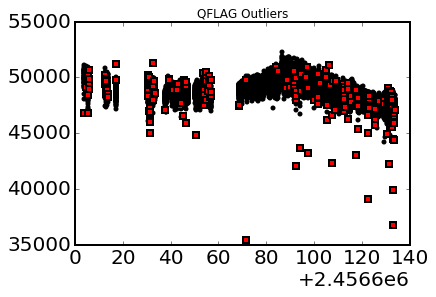

In [26]:
FLAG = data[:,columns['FLAG']]

#data flagged outliers removed

data_orem_qf = data[FLAG==1]

#outliers just in case you want to keep them

outliers_qf = data[FLAG==0]

plt.figure()
plt.title('QFLAG Outliers')
plt.plot(data_orem_qf[:,columns['HJD']], data_orem_qf[:,columns['FLUX']], 'k.')
plt.plot(outliers_qf[:,columns['HJD']], outliers_qf[:,columns['FLUX']], 'rs')
plt.show()

However, there are clearly some points here (especially toward the end) that seem just fine and it would be a shame to remove them. So let's see how outlier rejection does without them. If need be we can always remove them at the end so it doesn't hurt anything.


Okay, Everything up to this point has been pretty much unbreakable. Just apply corrections already in place. At this point you will have to start making some decisions. You could keep the data as is, but there are likely more outliers that should be removed. If an x or y position is significantly different from it's neighbors it's a good indication that fine pointing was lost in the telescope or something else just as nefarious happened. To measure this we only care about the position of a datapoint relative to it's neighbors. To measure this we need to get remove any long term trends in a given parameter. One way to do this is with a LOWESS filter. This essentially smooths the data, giving a good estimate of the long term trend. This filter is built in the statsmodel package.



In [10]:
HJD = data[:,columns['HJD']]
xPOS = data[:,columns['XCEN']]

xPOSlowess = sm.nonparametric.lowess(xPOS, HJD, frac=0.15)
time_l, xPOS_l = xPOSlowess[:,0], xPOSlowess[:,1]


With Lowess filtering, there is only one factor which you need to know: frac. This is a value from 0 to 1 which tells the code how much of the data you want to consider in each bin for determining the long term trend. Good values for our purposes are between 0.1 and 0.35, but let's not take my word for it. It takes a couple minutes to run lowess, but it's important so let's try a few different values and compare

In [11]:
xPOSlowess = sm.nonparametric.lowess(xPOS, HJD, frac=0.05)
time_l1, xPOS_l1 = xPOSlowess[:,0], xPOSlowess[:,1]

xPOSlowess = sm.nonparametric.lowess(xPOS, HJD, frac=0.67)
time_l2, xPOS_l2 = xPOSlowess[:,0], xPOSlowess[:,1]

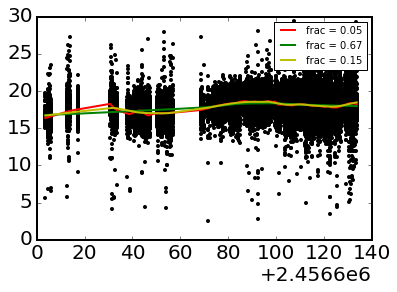

In [27]:
plt.figure()
plt.plot(HJD, xPOS, 'ko', markersize=2.0)
plt.plot(time_l1, xPOS_l1, 'r', lw=2.0, label='frac = 0.05')
plt.plot(time_l2, xPOS_l2, 'g', lw=2.0, label='frac = 0.67')
plt.plot(time_l, xPOS_l, 'y', lw=2.0, label='frac = 0.15')
plt.legend(prop={'size':10})
plt.show()

As we can see the higher frac gets the smoother it gets, which is good except that you miss any small trends which happen, especially in the region where the data is sparsly populated. If we go too far in the other direction, then it becomes then it becomes jerky and slightly discontinuous, which we don't normally want either. It's important to find a middle ground. In this case, we choose this middle ground at 0.2. However, it is something you might have to play with in your particular case. 

Next we need to remove this trend before we can perform outlier rejection. 

In [28]:
xPOS_corr = xPOS-xPOS_l

The actual rejection can be done in a myriad of ways, sigma clipping being the most standard. Here, however, we are using a slightly more general routine that clips based on percentages. This works in much the same way as sigma clipping except you can provide different percentages on either side of the distribution. This is especially handy if your distribution is not strictly gaussian and you want to make sure you aren't cutting unecessary points. While we're at it we'll keep track of our cuts, so that our data is reproduceable, by adding them to params dictionary.

In [29]:
percent_high = 1.5 #cut top 1.5 percent
percent_low = 1.5 #cut bottom 1.5 percent

In [30]:
xoutliers, xmask = percentageclipBRITE.percentageFILTER(xPOS_corr, percent_low, percent_high, full_output=True)

outliers_x = data[xoutliers]
data_orem = data[xmask]

params['xreject'] = [percent_high, percent_low]


Okay, so how are we doing so far? Let's plot and find out.

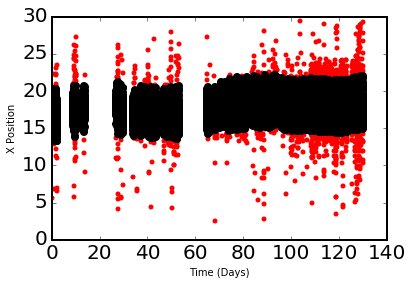

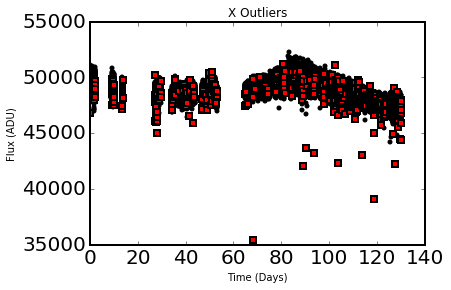

In [31]:
plt.figure()
plt.plot(HJD-HJD[0], xPOS, 'r.')
plt.plot(data_orem[:,columns['HJD']]-HJD[0], data_orem[:,columns['XCEN']], 'ko')
plt.xlabel('Time (Days)')
plt.ylabel('X Position')


plt.figure()
plt.title('X Outliers')
plt.plot(data_orem_qf[:,columns['HJD']]-HJD[0], data_orem_qf[:,columns['FLUX']], 'k.')
plt.plot(outliers_x[:,columns['HJD']]-HJD[0], outliers_x[:,columns['FLUX']], 'rs')
plt.xlabel('Time (Days)')
plt.ylabel('Flux (ADU)')
plt.show() 



This is good. We aren't using the quality flag and some of the points it flagged (seemingly incorrectly) and we seem to have gotten rid of most of the obvious outlier points in the light curve. So let's continue this way.


Unsurprisingly, we have to do the exact same procedure with the y position. Perhaps it is possible to correct for x,y position simultaneously, however we haven't been able to do it. If you do have any ideas here, please share.

In [32]:
percent_high = 1.5 #cut top 1.5 percent
percent_low = 1.5 #cut bottom 1.5 percent

In [33]:
yPOS = data[:,columns['YCEN']]
HJD = data[:,columns['HJD']]

yPOSlowess = sm.nonparametric.lowess(yPOS, HJD, frac=0.1)
time_l, yPOS_l = yPOSlowess[:,0], yPOSlowess[:,1]

yPOS_corr = yPOS-yPOS_l
youtliers, ymask = percentageclipBRITE.percentageFILTER(yPOS_corr, percent_low, percent_high,full_output=True)

outliers_y = data[youtliers]
data_orem2 = data[ymask]

params['yreject'] = [percent_high, percent_low]


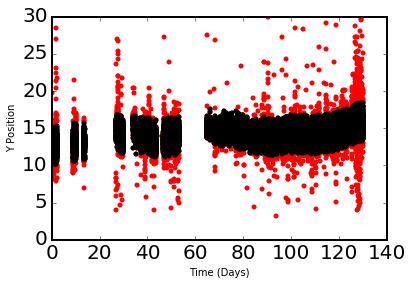

In [34]:
plt.figure()
plt.plot(HJD-HJD[0], yPOS, 'r.')
plt.plot(data_orem2[:,columns['HJD']]-HJD[0], data_orem2[:,columns['YCEN']], 'k.')
plt.xlabel('Time (Days)')
plt.ylabel('Y Position')
plt.show()

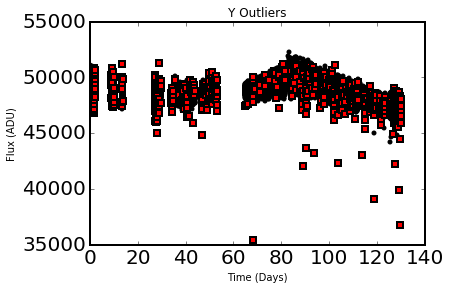

In [35]:
plt.figure()
plt.title('Y Outliers')
plt.plot(data_orem2[:,columns['HJD']]-HJD[0], data_orem2[:,columns['FLUX']], 'k.')
plt.plot(outliers_y[:,columns['HJD']]-HJD[0], outliers_y[:,columns['FLUX']], 'rs')
plt.xlabel('Time (Days)')
plt.ylabel('Flux (ADU)')
plt.show() 

Here's where it get's a bit tricky. You can try to do the same thing with temperature, and it might work well, like what I do below. However, it won't always. This example is with Orion I data, but after this the operators took measures to keep the temperature down which increases the photometric precision. The downside of this is that the clear temperature pattern seen here is much more discontinuous and difficult to remove in other data sets. For this a simple gui was developed to let you eliminate outliers one at a time. This will be talked about in a separate tutorial. For now we'll follow the procedure below.

In [36]:
percent_high = 1.0 #cut top 1.0 percent
percent_low = 0.5 #cut bottom 0.5 percent


HJD = data[:,columns['HJD']]
temp = data[:,columns['CCDT']]

TPOSlowess = sm.nonparametric.lowess(temp, HJD, frac=0.1)
time_l, TPOS_l = TPOSlowess[:,0], TPOSlowess[:,1]

TPOS_corr = temp-TPOS_l
toutliers, tmask = percentageclipBRITE.percentageFILTER(TPOS_corr, percent_low, percent_high, full_output=True)

outliers_t = data[toutliers]
data_orem3 = data[tmask]

params['tempreject'] = [percent_high, percent_low]


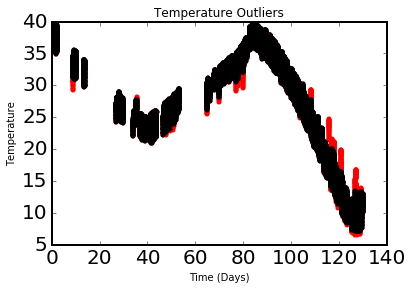

In [37]:
plt.figure()
plt.title('Temperature Outliers')
plt.plot(HJD-HJD[0], temp, 'r.')
plt.plot(data_orem3[:,columns['HJD']]-HJD[0], data_orem3[:,columns['CCDT']], 'k.')
plt.xlabel('Time (Days)')
plt.ylabel('Temperature')
plt.show()



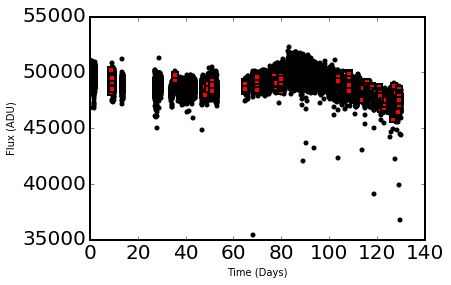

In [38]:
plt.figure()
plt.plot(data_orem3[:,columns['HJD']]-HJD[0], data_orem3[:,columns['FLUX']], 'k.')
plt.plot(outliers_t[:,columns['HJD']]-HJD[0], outliers_t[:,columns['FLUX']], 'rs')
plt.xlabel('Time (Days)')
plt.ylabel('Flux (ADU)')
plt.show() 


Now this is the part where you would do flux outliers. You can still do this if you like, but it is difficult to do as you are just at likely to remove real signal if you have strong variations in your light curve. So, to truly do this correctly, you would need a model of your data. Once you remove a model of your data, you can then look for flux outliers on the residuals. However, this is complicated and since you may not have a model (at least to start with) we'll move this to a separate tutorial.

Okay, we did a lot of work, so let's see how our results compare to quality flagged results and to each other. 


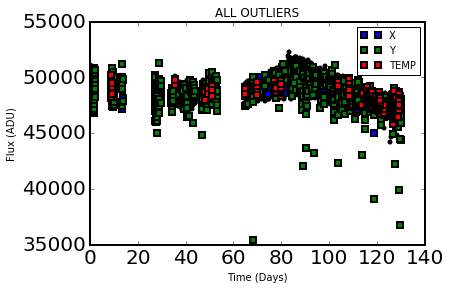

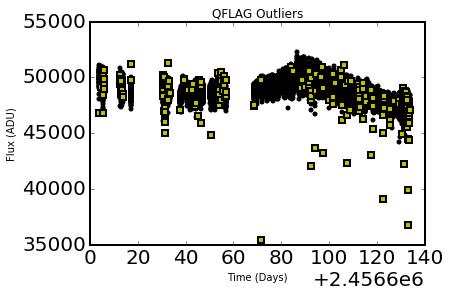

In [39]:
plt.figure()
plt.title('ALL OUTLIERS')
plt.plot(data[:,columns['HJD']]-HJD[0], data[:,columns['FLUX']], 'k.')
plt.plot(outliers_x[:,columns['HJD']]-HJD[0], outliers_x[:,columns['FLUX']], 'bs', label='X')
plt.plot(outliers_y[:,columns['HJD']]-HJD[0], outliers_y[:,columns['FLUX']], 'gs', label='Y')
plt.plot(outliers_t[:,columns['HJD']]-HJD[0], outliers_t[:,columns['FLUX']], 'rs', label='TEMP')
plt.xlabel('Time (Days)')
plt.ylabel('Flux (ADU)')
plt.legend(prop={'size':10})

plt.figure()

plt.title('QFLAG Outliers')
plt.plot(data_orem_qf[:,columns['HJD']], data_orem_qf[:,columns['FLUX']], 'k.')
plt.plot(outliers_qf[:,columns['HJD']], outliers_qf[:,columns['FLUX']], 'ys')
plt.xlabel('Time (Days)')
plt.ylabel('Flux (ADU)')
plt.show()

Now we take all the outliers that we found put them together and remove any repeats (and there will be several) creating a unique set to purge from our data.


In [40]:
xytoutliers = np.concatenate((xoutliers, youtliers, toutliers))
xytoutliers = set(list(xytoutliers))
xytoutliers= sorted(xytoutliers) #sort just so there is no confusion
outliers_xyt = data[xytoutliers]

#then create a new mask
xytmask = np.full(len(data), True, dtype=bool)
xytmask[xytoutliers]=False

data_orem = data[xytmask]


So, this takes care of most of our outliers, though we could be more thorough using the temperature gui. However, we do still have some issues. A few points look too low. At this point, we could leave these guys for now, or we can do a quick sigma clip on each orbit. That way if these points are really outliers within a given orbit they will be dealt with. This step is optional, but it is unlikely to get rid of any useful points.


In [41]:
orbper = params['orbper']

data_orem_f = be.orb_clip(data_orem, orbper, sig=3.0)

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


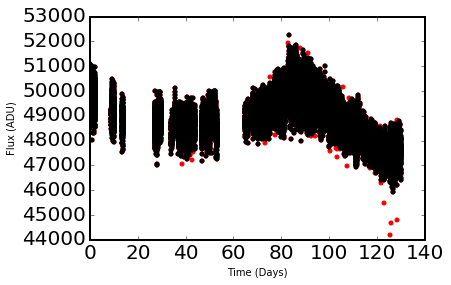

In [42]:
plt.figure()
plt.plot(data_orem[:,columns['HJD']]-HJD[0], data_orem[:,columns['FLUX']], 'r.')
plt.plot(data_orem_f[:,columns['HJD']]-HJD[0], data_orem_f[:,columns['FLUX']], 'k.')
plt.xlabel('Time (Days)')
plt.ylabel('Flux (ADU)')
plt.show()


And finally let's save the file. Luckily, this is really simple as I wrote a function to do just that. It is essentially just a wrapper around numpy's savetxt, but if you give it the columns and params dictionary, it will delete the  quality FLAG column as that is unnecessary and append a your params dictionary as a header.


In [43]:
filename = str(targ)+'_'+str(obsid)+'_'+str(tel)+'_setup'+str(setup)+'_orem.dat'

load.save_dataset(filename, data_orem_f, columns=columns, params=params)



As you can see each outlier step can take a bit of playing around to get it acceptable. If you want you can save the file after any step. You will lose the quality FLAG column but that isn't so bad. However, if you would like to save the file and keep this information simply don't provide the columns dictionary.

One final note. Outlier rejection, while not being arbitrary, does depend a lot on your preferences. I tend to reject as little as possible, trying to keep data unless it is obviously bad. You may decide that these few extra data points are not worth the hassle and cut more. On the other hand, you may decide to cut even less, because some points which may be real are being removed. There will be a bit of trial and error here, but don't get too bogged down in the details. 
